In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.signal import butter, filtfilt
from scipy.ndimage import gaussian_filter
import control as ctl

In [2]:
df = pd.read_csv('DataBase.csv')
df.head()

,time,input
0,110.062839,4034.0
1,110.141765,4045.0
2,110.221532,4059.0
3,110.301835,4044.0
4,110.382143,4043.0


In [3]:
def normalizeData(df, timeKey, responseKey, T=0.15):
    initTime  = df[timeKey].iloc[0]
    finalTime = df[timeKey].iloc[-1] + T
    timeData  = np.arange(initTime, finalTime, T)
    
    lastValue = df[responseKey].iloc[0]
    desired = []

    for t in timeData:
        filtered = df.loc[df[timeKey] <= t][responseKey]
        
        if not filtered.empty:
            lastValue = filtered.iloc[-1]
        
        desired.append(lastValue)
    
    return timeData, desired


def normalizeTable(df, key, T=0.15):
    table = {key: []}

    for column in df.columns:
        if column == key:
            continue

        xData, yData = normalizeData(df, key, column, T)
        table[column] = yData

    table[key] = xData
    return pd.DataFrame(table) 


dt = 0.030
df['time'] = df.time - df.time[0]
df = normalizeTable(df, 'time', dt)
df.head()

,time,input
0,0.00,4034.0
1,0.03,4034.0
2,0.06,4034.0
3,0.09,4045.0
4,0.12,4045.0


In [4]:
xData = df.time.values
yData = df.input.values

# IMPLEMENTANDO OS FILTROS
- Filtro de Butterworth

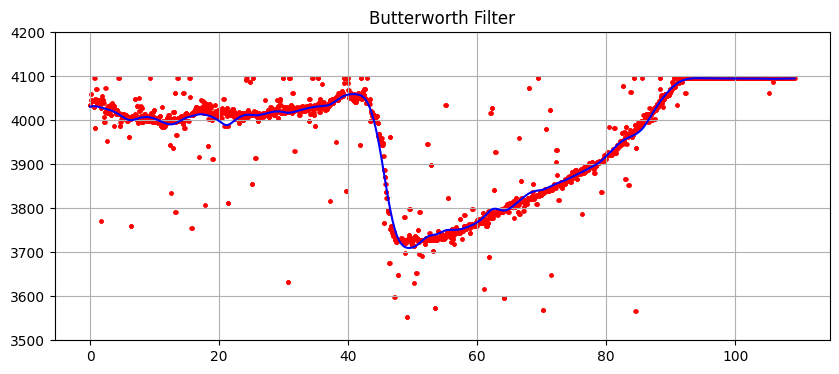

In [5]:
order = 2           # Ordem do filtro
cutoff_freq = 0.01  # Frequência de corte (ajuste conforme seu sinal)
b, a = butter(order, cutoff_freq, btype='low', analog=False)
yButter = filtfilt(b, a, yData)

plt.figure(figsize=(10, 4))
plt.title(f'Butterworth Filter')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yButter, color='blue')
plt.ylim(3500, 4200)
plt.grid()

- Filtro de Laplace

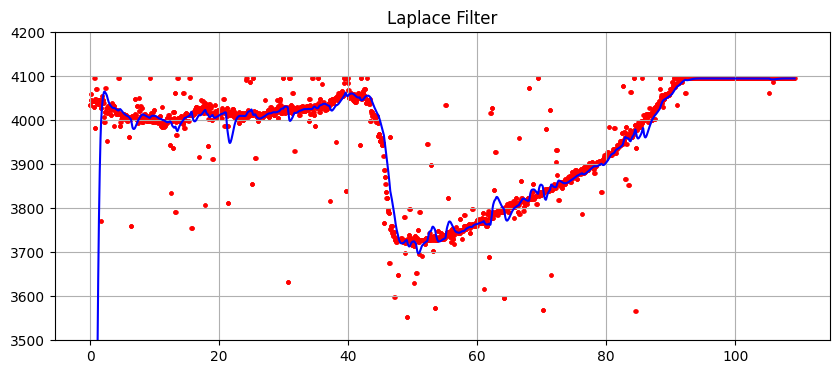

In [6]:
class LaplaceFilter:
    num = []
    den = []
    
    def __init__(self, Ts=1.0, UP=0.1, dt=0.05, Tp=None):
        zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
        Wn   = 4/(zeta*Ts)

        if Tp is not None:
            Wn = np.pi/(Tp*np.sqrt(1 - zeta**2))

        s = ctl.TransferFunction.s
        C = Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2)

        C_z = ctl.c2d(C, dt, method='tustin')
        self.num, self.den = self.getFraction(C_z)
        self.Xn = np.zeros_like(self.num)
        self.Yn = np.zeros_like(self.den)
        self.dt = dt

    def getFraction(self, G_z):
        num, den = ctl.tfdata(G_z)
        num = np.squeeze(num)
        den = np.squeeze(den)

        num = num/den[0]
        den = den/den[0]

        if type(num) == np.float64:
            num = np.array([num])

        num = [float(val) for val in num]
        den = [float(val) for val in den]
        return (num, den) 

    def compute(self):
        out = 0.0

        for i in range(0, len(self.num)):
            out += self.Xn[i]*(self.num[i])
        
        for i in range(1, len(self.den)):
            out += self.Yn[i]*(-1*self.den[i])

        return out

    def update(self, input):
        for n in range(len(self.num)-1, 0, -1):
            self.Xn[n] = self.Xn[n-1]

        for n in range(len(self.den)-1, 0, -1):
            self.Yn[n] = self.Yn[n-1]
        
        self.Xn[0] = input
        self.Yn[0] = self.compute()
        return self.Yn[0]
    

filter = LaplaceFilter(Ts=2.0, UP=0.01, dt=dt)
yLaplace = np.array([filter.update(val) for val in yData])

plt.figure(figsize=(10, 4))
plt.title(f'Laplace Filter')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yLaplace, color='blue')
plt.ylim(3500, 4200)
plt.grid()

- Filtro Gaussiano

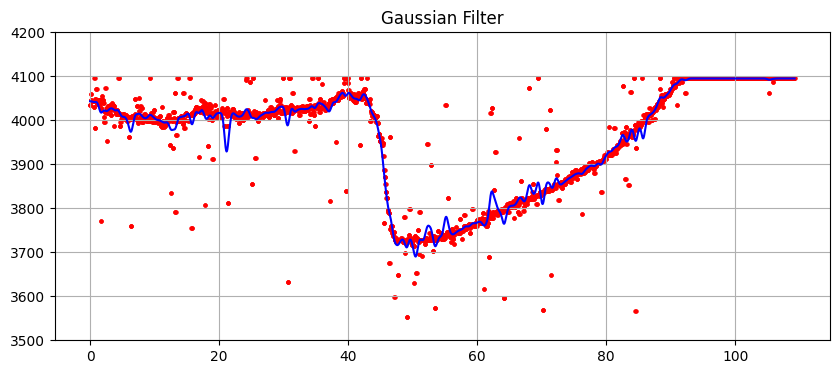

In [7]:
yGaussian = gaussian_filter(yData, sigma=10)

plt.figure(figsize=(10, 4))
plt.title(f'Gaussian Filter')
plt.scatter(xData, yData, s=5, color='red')
plt.plot(xData, yGaussian, color='blue')
plt.ylim(3500, 4200)
plt.grid()

# FUSÃO COVARIANCE INTERSECTION (CI)
- x1, x2: estimativas (escalares)
- P1, P2: variâncias (escalares)
- w: parâmetro de fusão em [0, 1]
- Retorna (x_f, P_f): estimativa fundida e variância fundida

In [8]:
def fuse(x1, P1, x2, P2, w=0.5):
    P1_inv = 1.0 / P1
    P2_inv = 1.0 / P2

    PF_inv = w * P1_inv + (1.0 - w) * P2_inv
    PF = 1.0 / PF_inv
    
    xf = PF * ( w * P1_inv * x1 + (1.0 - w) * P2_inv * x2 )
    return xf, PF

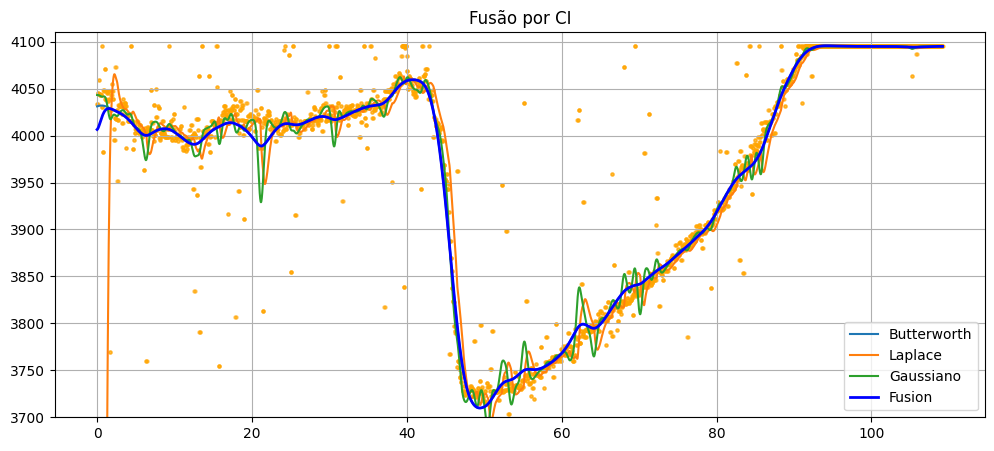

In [9]:
yModel = []

for i in range(len(yData)):
    xButter, varButter     = (yButter[i],   1.0)
    xLaplace, varLaplace   = (yLaplace[i],  5.0)
    xGaussian, varGaussian = (yGaussian[i], 15.0)
    
    out1, pf1 = fuse(xButter, varButter, xLaplace, varLaplace, w=0.97)
    out2, pf2 = fuse(out1, pf1, xGaussian, varGaussian, w=0.95)
    yModel.append(out2)


plt.figure(figsize=(12, 5))
plt.title('Fusão por CI')
plt.scatter(xData, yData, s=5, color='orange', alpha=0.5)
plt.plot(xData, yButter,   label='Butterworth')
plt.plot(xData, yLaplace,  label='Laplace')
plt.plot(xData, yGaussian, label='Gaussiano')
plt.plot(xData, yModel, label='Fusion', linewidth=2, color='blue')
plt.ylim(3700, 4110), plt.legend(), plt.grid()
plt.show()

# FUSÃO POR KALMAN
- x0: valor inicial do estado
- P0: variância inicial do estado
- Q:  variância do ruído de processo
- R:  matriz de covariância de medição (3x3, por exemplo, se há 3 medições)

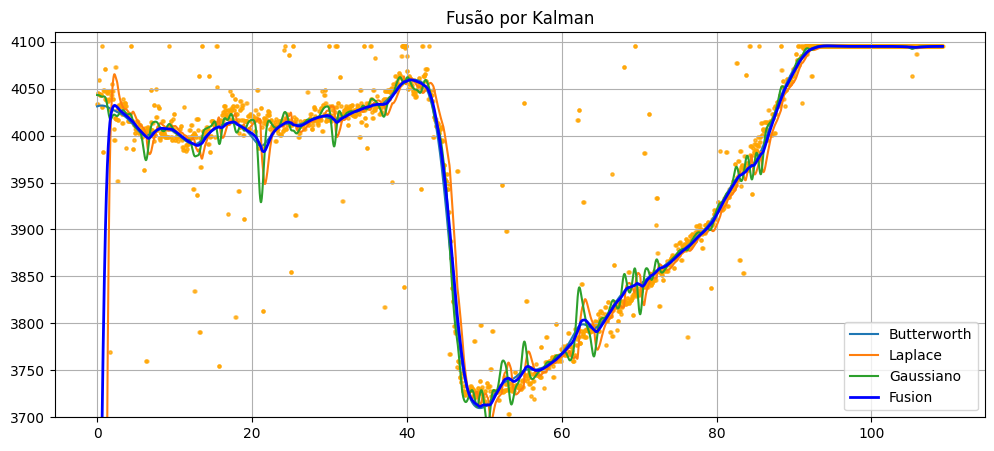

In [10]:
class KalmanFilter1D:
    def __init__(self, x0=0.0, P0=1e3, Q=1e-2, R=None):
        self.x = x0
        self.P = P0
        self.Q = Q 
        
        if R is None:
            R = np.diag([1.0, 5.0, 10.0])
        
        self.R = R
        num_meas = self.R.shape[0]
        self.H = np.ones((num_meas, 1), dtype=float) 

    def predict(self):
        self.x = self.x 
        self.P = self.P + self.Q

    def update(self, z, R_override=None):
        R = self.R if R_override is None else R_override
        z = np.asarray(z).reshape(-1) 
        y = z - self.H[:, 0] * self.x 
        HPHt = (self.P) * (self.H @ self.H.T) 
        S = HPHt + R
        K = self.P * (self.H.T @ np.linalg.inv(S))
        self.x = self.x + K.dot(y)
        KH = K @ self.H
        self.P = (1.0 - KH)[0] * self.P
        return self.x


Q = 0.1
R = np.diag([1.0, 5.0, 10.0])  

kalman = KalmanFilter1D(x0=yData[0], P0=100.0, Q=Q, R=R)
yModel = []

for i in range(len(xData)):
    data = np.array([yButter[i], yLaplace[i], yGaussian[i]])
    kalman.predict()
    output = kalman.update(data)[0]
    yModel.append(output)


plt.figure(figsize=(12, 5))
plt.title('Fusão por Kalman')
plt.scatter(xData, yData, s=5, color='orange', alpha=0.5)
plt.plot(xData, yButter,   label='Butterworth')
plt.plot(xData, yLaplace,  label='Laplace')
plt.plot(xData, yGaussian, label='Gaussiano')
plt.plot(xData, yModel, label='Fusion', linewidth=2, color='blue')
plt.ylim(3700, 4110), plt.legend(), plt.grid()
plt.show()


In [11]:
df = pd.DataFrame({
    'time': xData,
    'data': yData,
    'butter': yButter,
    'laplace': yLaplace,
    'gaussian': yGaussian,
    'target': (yButter*0.80 + yLaplace*0.10 + yGaussian*0.10)
})

df.to_csv('../Model/DataBase.csv', index=None)
df.head()

,time,data,butter,laplace,gaussian,target
0,0.00,4034.0,4031.067104,5.012830,4043.200379,3629.675004
1,0.03,4034.0,4031.155260,24.472450,4043.194593,3631.690912
2,0.06,4034.0,4031.240059,61.661509,4043.182411,3635.476439
3,0.09,4045.0,4031.321277,114.404215,4043.162852,3640.813728
4,0.12,4045.0,4031.398696,180.707141,4043.134650,3647.503136
